In [54]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [55]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_34759/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [56]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [57]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [58]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'calc_fvc_abs', 'exc_ever', 'high_calc_bili', 'vad_brand2_tcr', 'dis_alkphos', 'hrsevfailsodiumdt', 'cvp_cath_old_don', 'form_valid_dt', 'malig_denovo_tumor_29_dx_date', 'num_li_tx', 'preop_creat_li', 'creat_don', 'end_bmi_calc', 'region', 'wl_id_code', 'prostacyclin_tcr', 'growth1', 'kaposi_visceral_donor', 'cptestrer', 'hemocvpst', 'creat_trr', 'val_dt_tcr', 'insulin_end_dt', 'cardiomyopathysuddendeath', 'heparin_end_dt', 'inr', 'brain_death_time', 'ecmowithouthemoalt', 'exthemodynamicmonitoring', 'preop_sgpt_alt', 'prim_hepatic_donor', 'skin_basal', 'urine_inf_don', 'oth_life_sup_tcr', 'extmeanpressuredt', 'last_inact_reason', 'max_mismatch_adr', 'hemo_pcw_tcr', 'hrsevfailsodiumst', 'distance', 'cod_liv_don', 'num_pa_recov', 'cardiomyopathynyhapcwp', 'growth6', 'age_diab', 'criteriamcsdwithpump', 'ki_creat_preop', 'vadldhlevels', 'extinomuldopamine', 'oth_cancer_donor', 'thyroid', 'high_creat_dt', 'postop_inr', 'extinotropedobutamine', 'malig_denovo_tumor_25_dx_d

Let's investigate the columns with unknown type.

In [59]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [60]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'alg_ind', 'astagrafxl_maint', 'gengraf_ind', 'nulojix_maint', 'prograf_maint', 'thymoglobulin_maint', 'solubleil1receptor_ind', 'campath_ind', 'oth_drug_ostxt1', 'antiil6_maint', 'thymoglobulin_ind', 'brequinarsodium_ind', 'mizoribine_maint', 'simulect_maint', 'antitnf_maint', 'myfortic_ind', 'antiicam1_ind', 'envarsusxr_ind', 'genericmyfortic_maint', 'methotrexate_ind', 'antitnf_ind', 'okt3_ind', 'imuran_maint', 'xomazymecd5_ind', 'antiil6_ind', 'rapamune_maint', 'envarsusxr_maint', 'alg_maint', 'dab486il2_ind', 'okt3_maint', 'oth_drug_ind1', 'leflunomide_maint', 'antiicam1_maint', 'rituxan_ind', 'antilfa1_maint', 'atgam_ind', 'oth_drug_maint1', 'eon_maint', 'zenapax_maint', 'prograf_ind', 'cytoxan_ind', 'genericcyclosporin_maint', 'aldesleukin_ind', 'fty720_ind', 'antilfa1_ind', 'oth_drug_ostxt2', 'nratgnrats_maint', 'generictacrolimus_ma

Let's investigate the types of these columns.

In [61]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

0.00000    20
1.00000    19
Name: alg_ind, dtype: int64
1.00000    148
Name: astagrafxl_maint, dtype: int64
0.00000    1945
1.00000     156
Name: gengraf_ind, dtype: int64
1.00000    13
Name: nulojix_maint, dtype: int64
1.00000    26215
0.00000      110
Name: prograf_maint, dtype: int64
0.00000    10516
1.00000       46
Name: thymoglobulin_maint, dtype: int64
0.00000    7
Name: solubleil1receptor_ind, dtype: int64
1.00000    500
0.00000      2
Name: campath_ind, dtype: int64
IVIG                                                  391
AZATHIOPRINE                                          121
CELLCEPT                                              106
PLASMAPHERESIS                                         50
SIMULECT (CHI)                                         43
PREDNISONE                                             39
CYTOXAN                                                38
BORTEZOMIB                                             34
BLINDED:AZATHIOPRINE&MYCOPHENO                         3

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [62]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [63]:
# sort columns by number of unique values
categoric_sorted_unique = d[list(categorical_columns & set(d.columns))].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

cod                         76
cod_wl                      63
thoracic_dgn                56
malig_ty_tcr                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_trr               25
func_stat_tcr               25
func_stat_trf               25
rem_cd                      18
init_stat                   11
end_stat                    11
tcr_dur_abstain              9
abo_don                      9
abo                          9
vad_tah_tcr                  8
vad_tah_trr                  8
ethcat_don                   8
education                    8
ethcat                       8
broncho_rt_don               8
broncho_lt_don               8
chest_xray_don               7
vad_device_ty_tcr            6
diab                         6
hist_diabetes_don            6
academic_level_trr           6
vad_device_ty_trr            6
motor_dev_trr                5
cognitive_dev_trr            5
academic_prg_tcr             5
academic_prg_trr             5
academic

Let's similarly investigate if any numeric columns have too few unique values.

In [64]:
numeric_sorted_unique = d[list(numerical_columns & set(d.columns))].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
rvad_at_listing                      1
pco2_trr                             1
lvad_at_listing                      1
lvad_while_listed                    1
rvad_while_listed                    1
iabp_trr                             2
fvc_trr                              2
inotropes_tcr                        2
ecmo_trr                             2
inhaled_no                           2
inotropes_trr                        2
gstatus                              2
ventilator_tcr                       2
pge_trr                              2
ecmo_tcr                             2
iabp_tcr                             2
fev1_trr                             2
drmis                                3
amis                                 3
bmis                                 3
exercise_o2                          4
sternotomy_tcr                       4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [65]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [66]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [67]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

Let's additionally convert the date columns to comparable timestamps.

In [68]:
for col in date_columns:
    d[col] = pd.to_datetime(d[col], format="%d%b%Y")

# Removal of unwanted data

We want to remove all data of people under the age of 18.

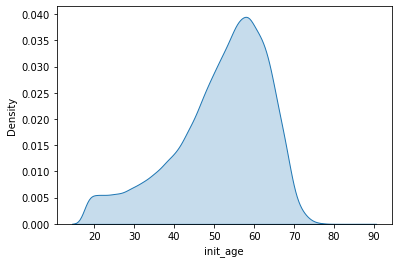

In [69]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, fill=True)
plt.show()

Furthermore, we need to somehow merge entries belonging to the same patient.

One way to handle this is to just drop all rows of patients with more than one record in the waitlist. However, this might be a bit crude if there are many patients with multiple records.

Proportion of patients with more than one record: 0.07628644895324749
0    12314
1     2917
2       84
3       13
Name: num_prev_tx, dtype: int64
0     87734
1       925
2        53
3         8
5         3
6         2
10        2
4         2
9         1
7         1
Name: num_prev_tx, dtype: int64


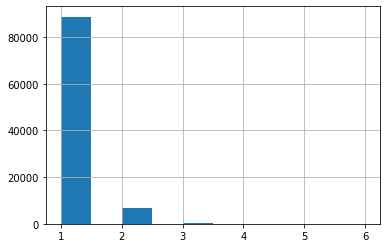

In [70]:
rcount = d.groupby("pt_code").wl_org.count()
rcount.hist()

gt1 = rcount[rcount > 1]

# print proportion of patients with at least 2 records
print("Proportion of patients with more than one record:", len(gt1) / d.pt_code.nunique())

# of those with more than one record, print the value counts for "num_prev_tx"
print(d[d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())
# num_prev_tx for those with only one record
print(d[~d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())

There are a significant amount of patients with multiple records, but by experimentation, keeping one record of each patients or removing them all patients with multiple records produced very similar results.

For now, we will remove all patients with duplicate entries.

In [71]:
d.sort_values(by=['pt_code', 'num_prev_tx', 'init_date'], inplace=True)
#d.drop_duplicates(subset=['pt_code', 'num_prev_tx'], keep='last', inplace=True)

# Remove all patients with multiple records
d.drop_duplicates(subset=['pt_code'], keep=False, inplace=True)

There is a large amount of possible outcomes for each patient, detailed in the column rem_cd. Most of these outcomes have barely any patients assigned to them. We will filter the data set to only include the most common outcomes.

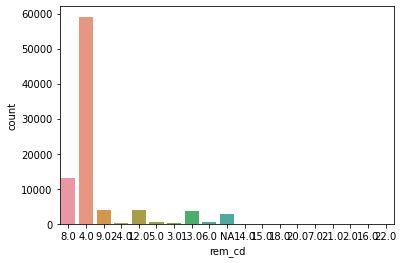

In [72]:
sns.countplot(x="rem_cd", data=d.fillna("NA"))
plt.show()

Let's remove all outcomes except transplant and death.

In [73]:
d = d[d.rem_cd.isin([4,8,13])]

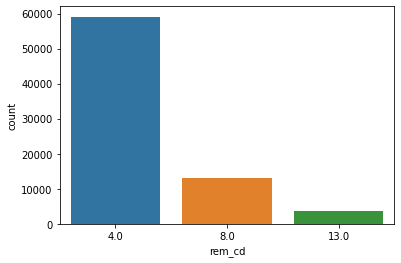

In [74]:
sns.countplot(x="rem_cd", data=d.fillna("NA"))
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

We're not interested in any patients that have a negative waitlist time.

In [75]:
neg = d[d.end_date < d.init_date]
print("Numer of negative wait times:", len(neg))
d.drop(neg.index, inplace=True)

Numer of negative wait times: 4


Extreme outliers will be removed based on quantile.

In [76]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()

d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns].lt(upper)) & (d2[numerical_columns].gt(lower))]
d, d2 = d2, d

Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

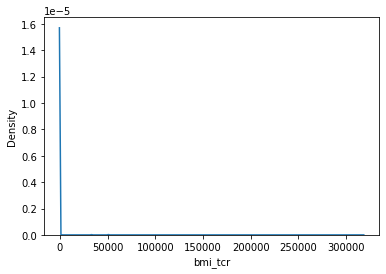

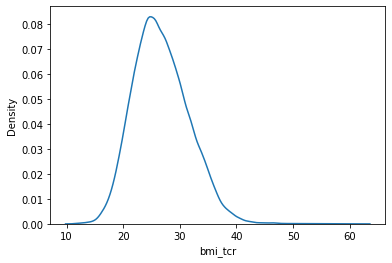

In [77]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [78]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]
selected_vars.remove("init_creat") # only contains missing values

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 34


Let's prepare a time to death variable to categorize death outcomes in different time periods.

To accomplish this, we need to determine which columns will help us determine time to death.

In [79]:
d["total_wl_time"] = (d.end_date - d.init_date).dt.days

print(f"%missing values in total_wl_time: {d.total_wl_time.isna().sum() / len(d) * 100:.2f}%")
print(f"%missing values in dayswait_chron: {d.dayswait_chron.isna().sum() / len(d) * 100:.2f}%")

# for non missing rows of dayswait_chron, check if total_wl_time is equal to dayswait_chron
print(f"%rows where total_wl_time is equal to dayswait_chron: {(d[d.dayswait_chron.notna()].total_wl_time == d[d.dayswait_chron.notna()].dayswait_chron).sum() / len(d) * 100:.2f}%")

%missing values in total_wl_time: 0.00%
%missing values in dayswait_chron: 0.35%
%rows where total_wl_time is equal to dayswait_chron: 99.65%


Given the similarity between dayswait_chron and the calculated column total_wl_time, and the fact that total_wl_time has no missing values, dayswait_chron is useless.

There is also a column, composite_death_date, that has the least missing values of death related columns. We can use this to calculate a time_to_death variable.

count   43621.00000
mean     2107.88540
std      2302.22015
min         0.00000
25%       192.00000
50%      1172.00000
75%      3525.00000
max     11771.00000
%NA          42.50%
Name: time_to_death, dtype: object


<AxesSubplot: >

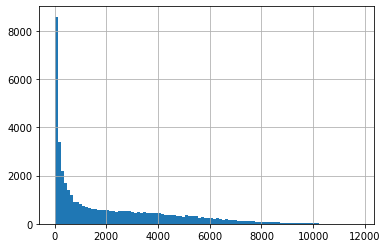

In [80]:
d["time_to_death"] = (d.composite_death_date - d.init_date).dt.days
desc = d.time_to_death.describe()
desc["%NA"] = f"{d.time_to_death.isna().sum() / len(d) * 100:.2f}%"
print(desc)
d.time_to_death.hist(bins=100)

We see a lot of NA values, but not as much for actual death outcomes:

In [81]:
desc = d[d.rem_cd.isin([8, 13])].time_to_death.describe()
desc["%NaN"] = f"{d[d.rem_cd.isin([8, 13])].time_to_death.isna().sum() / len(d[d.rem_cd.isin([8, 13])]) * 100:.2f}%"
print(desc)

count   13492.00000
mean      427.18581
std       712.04274
min         0.00000
25%        32.00000
50%       136.00000
75%       505.00000
max      7910.00000
%NaN         19.60%
Name: time_to_death, dtype: object


Let's compare the usability of time_to_death and total_wl_time.

<AxesSubplot: >

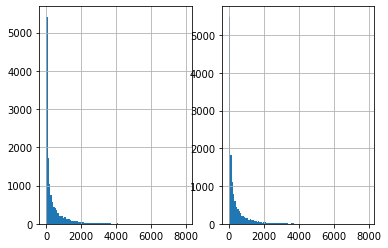

In [82]:
plt.subplot(1, 2, 1)
d[d.time_to_death.notna() & d.rem_cd.isin([8,13])].time_to_death.hist(bins=100)
plt.subplot(1, 2, 2)
d[d.time_to_death.notna() & d.rem_cd.isin([8,13])].total_wl_time.hist(bins=100)

In [83]:
desc = d[d.rem_cd.isin([8, 13])].total_wl_time.describe()
desc["%NaN"] = f"{d[d.rem_cd.isin([8, 13])].total_wl_time.isna().sum() / len(d[d.rem_cd.isin([8, 13])]) * 100:.2f}%"
print(desc)

count   16781.00000
mean      359.89542
std       612.00411
min         0.00000
25%        28.00000
50%       117.00000
75%       419.00000
max      7910.00000
%NaN          0.00%
Name: total_wl_time, dtype: object


As one might suspect, total wait list time is in general longer than time to death. Let's use time_to_death, but first: let's deal with the missing values by imputing them using KNN.

In [84]:
# K-nearest neighbors imputation of time_to_death, only based on total_wl_time and rem_cd
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=50)
d2 = d[d.rem_cd.isin([8,13])].copy()
imputed_ix = d2[d2.time_to_death.isna()].index
d2["time_to_death"] = imputer.fit_transform(d2[["total_wl_time", "time_to_death", "rem_cd"]])[:, 1]
d.loc[d2.index, "time_to_death"] = d2.time_to_death

Let's visualize the imputed values with respect to the colums time_to_death, total_wl_time, and rem_cd:

/tmp/ipykernel_34759/489808016.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x="total_wl_time", y="time_to_death", data=d.iloc[imputed_ix][d.rem_cd == rem], color="red")


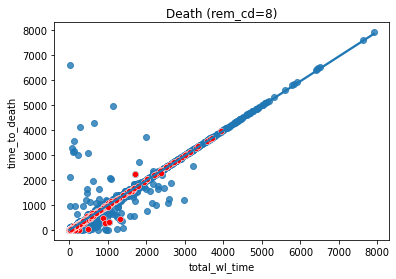

/tmp/ipykernel_34759/489808016.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x="total_wl_time", y="time_to_death", data=d.iloc[imputed_ix][d.rem_cd == rem], color="red")


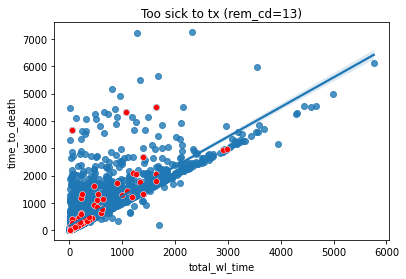

In [85]:
for rem in 8,13:
    d2 = d[d.rem_cd == rem].copy()
    d2.dropna(subset=["total_wl_time", "time_to_death"], inplace=True)
    sns.regplot(x="total_wl_time", y="time_to_death", data=d2)
    
    # plot imputed values
    sns.scatterplot(x="total_wl_time", y="time_to_death", data=d.iloc[imputed_ix][d.rem_cd == rem], color="red")
    plt.title("Death (rem_cd=8)" if rem == 8 else "Too sick to tx (rem_cd=13)")
    plt.show()

This imputation looks OK and should give us more useable data to work with.

Let's divide the dataset into four groups of roughly the same size based on which period they died if their outcome is death (rem_cd in 8,13): 0m-1m, 1m-3m, 3m-1y, 1y+. Orange plot is patients with death outcome.

In [86]:
d.time_to_death.quantile([1/3, 2/3])

0.33333    303.00000
0.66667   2411.66667
Name: time_to_death, dtype: float64

<AxesSubplot: >

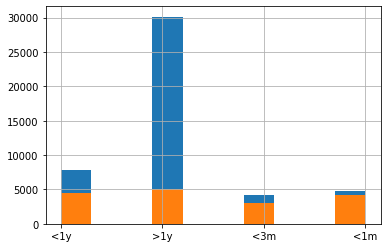

In [87]:
bins = [0, 30, 90, 365, float('inf')]
death_labels = ["<1m", "<3m", "<1y", ">1y"]
d["death_group"] = pd.cut(d.time_to_death, bins=bins, labels=death_labels)
d.death_group.hist()
d[d.rem_cd.isin([8, 13])].death_group.hist()

In [88]:
d["outcome"] = d.apply(
    lambda row: 
        "tx" if row.rem_cd == 4 # transplant
        else row.death_group, axis=1) # death in different time intervals
labels = ["tx", "<1m", "<3m", "<1y", ">1y"]

In [89]:
# Drop 90% of patients with tx outcome
drop_ix = d[d.outcome == "tx"].sample(frac=0.9, random_state=1).index
d = d.drop(drop_ix)

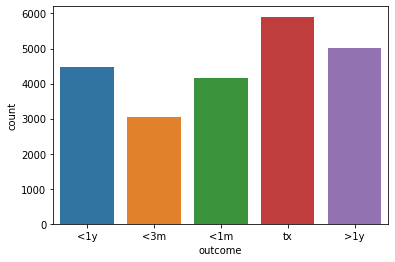

In [90]:
# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [36]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True, dropna=False))

tx    0.77879
>1y   0.06612
<1y   0.05902
<1m   0.05475
<3m   0.04029
NaN   0.00104
Name: outcome, dtype: float64


In [91]:
# drop NA outcomes
d.dropna(subset=["outcome"], inplace=True)

In [92]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 26
Number date columns: 0
Number drug columns: 0


# Imputation

Let's add "missing value" columns.

In [93]:
# add missing indicator to numerical columns with missing values
for col in numerical_columns:
    if d[col].isna().any():
        d[col + "_missing"] = d[col].isna().astype(int)

In [40]:
d.head()

,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,education,ecmo_tcr,iabp_tcr,inotropes_tcr,func_stat_tcr,diab,dial_ty_tcr,cereb_vasc,malig_tcr,most_rcnt_creat,tot_serum_album,hemo_co_tcr,cig_use,prior_card_surg_tcr,init_stat,init_age,ethnicity,init_hgt_cm_calc,init_wgt_kg_calc,ventilator_tcr,lvad_at_listing,rvad_at_listing,work_income_tcr,academic_level_tcr,outcome,wgt_kg_tcr_missing,hemo_co_tcr_missing,init_hgt_cm_calc_missing,most_rcnt_creat_missing,init_age_missing,hgt_cm_tcr_missing,tot_serum_album_missing,init_wgt_kg_calc_missing
27162,1999,N,N,N,N,NaN,M,O,88.00000,183.00000,NaN,0,0,0,996.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,2030.00000,46.00000,0,183.00000,88.00000,0,NaN,NaN,NaN,996.00000,<1y,0,1,0,1,0,0,1,0
19096,1200,N,N,N,N,N,M,O,90.72000,183.00000,5.00000,0,0,0,2.00000,5.00000,1.00000,N,Y,NaN,NaN,3.40000,NaN,U,2030.00000,35.00000,0,183.00000,90.72000,0,NaN,NaN,NaN,NaN,<1y,0,0,0,1,0,0,1,0
119608,1000,NaN,NaN,NaN,NaN,NaN,F,B,79.37870,160.02000,3.00000,0,0,0,2.00000,1.00000,1.00000,N,N,1.00000,4.70000,4.50000,NaN,U,2030.00000,50.00000,0,160.02000,79.37870,0,NaN,NaN,NaN,NaN,tx,0,0,0,0,0,0,0,0
58780,1000,NaN,NaN,NaN,NaN,NaN,M,A,124.73800,190.50000,4.00000,0,0,1,996.00000,5.00000,1.00000,N,N,1.10000,3.80000,7.00000,NaN,U,2010.00000,51.00000,0,190.50000,124.73800,0,NaN,NaN,NaN,NaN,tx,0,0,0,0,0,0,0,0
75972,1200,N,N,N,N,NaN,M,B,59.00000,168.00000,NaN,0,0,0,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,2030.00000,62.00000,0,168.00000,59.00000,0,NaN,NaN,NaN,NaN,tx,0,1,0,1,0,0,1,0


Finally, let's impute the missing values.

In [94]:
# impute numerical columns with the mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())
# TODO: impute with randomness

# Normalization and encoding

Now, let's normalize numerical values.

In [95]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [96]:
d = pd.get_dummies(d, columns=categorical_columns, drop_first=False)

In [97]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 155


# Model training

Useful functions:

In [100]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_evaluation(y_test, y_pred, labels=None):
    print(classification_report(y_test, y_pred, labels=labels))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

def print_training_history(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)

In [101]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train_d = pd.get_dummies(y_train)
y_val_d = pd.get_dummies(y_val)
y_test_d = pd.get_dummies(y_test)

## Simple Logistic Regression Model

              precision    recall  f1-score   support

          tx       0.70      0.75      0.72      1177
         <1m       0.49      0.65      0.56       853
         <3m       0.25      0.03      0.05       587
         <1y       0.33      0.28      0.30       861
         >1y       0.52      0.68      0.59      1044

    accuracy                           0.53      4522
   macro avg       0.46      0.48      0.44      4522
weighted avg       0.49      0.53      0.49      4522



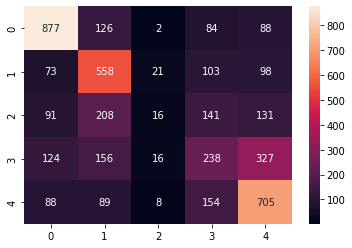

In [102]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred = model.predict(X_test)

print_evaluation(y_test, y_pred, labels=labels)

## 1*8 Neural Network

In [103]:
# 1*8 Neural network
from keras.models import Sequential
from keras.layers import Dense

m8 = Sequential([
    Dense(8, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# no early stopping, model too simple to overfit
history = m8.fit(X_train, y_train_d, epochs=30, validation_data=(X_val, y_val_d))

Epoch 1/30
453/453 [==============================] - 3s 5ms/step - loss: 1.4854 - accuracy: 0.3480 - val_loss: 1.3521 - val_accuracy: 0.4420
Epoch 2/30
453/453 [==============================] - 1s 2ms/step - loss: 1.2582 - accuracy: 0.4773 - val_loss: 1.2198 - val_accuracy: 0.4876
Epoch 3/30
453/453 [==============================] - 1s 2ms/step - loss: 1.1911 - accuracy: 0.4961 - val_loss: 1.1973 - val_accuracy: 0.4939
Epoch 4/30
453/453 [==============================] - 1s 2ms/step - loss: 1.1707 - accuracy: 0.5006 - val_loss: 1.1966 - val_accuracy: 0.4862
Epoch 5/30
453/453 [==============================] - 1s 2ms/step - loss: 1.1620 - accuracy: 0.5019 - val_loss: 1.1781 - val_accuracy: 0.4917
Epoch 6/30
453/453 [==============================] - 1s 2ms/step - loss: 1.1558 - accuracy: 0.5044 - val_loss: 1.1754 - val_accuracy: 0.4912
Epoch 7/30
453/453 [==============================] - 1s 1ms/step - loss: 1.1506 - accuracy: 0.5048 - val_loss: 1.1755 - val_accuracy: 0.4909
Epoch 

142/142 [==============================] - 0s 946us/step


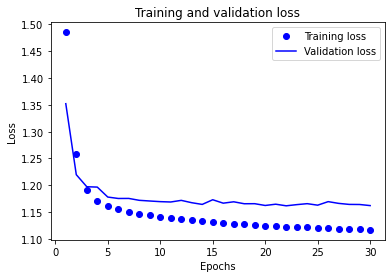

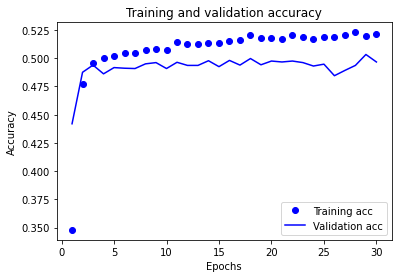

              precision    recall  f1-score   support

          tx       0.65      0.78      0.71      1177
         <1m       0.51      0.63      0.56       853
         <3m       0.20      0.01      0.03       587
         <1y       0.31      0.20      0.24       861
         >1y       0.51      0.70      0.59      1044

    accuracy                           0.52      4522
   macro avg       0.43      0.47      0.43      4522
weighted avg       0.47      0.52      0.48      4522



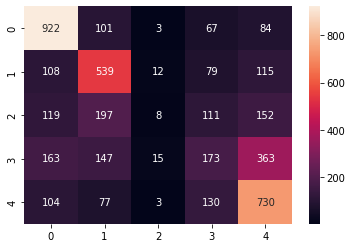

In [104]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m8.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 1*16 Neural Network

In [105]:
# 1*16 neural network
from keras.models import Sequential
from keras.layers import Dense

m16 = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m16.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 1.4411 - accuracy: 0.3925 - val_loss: 1.3130 - val_accuracy: 0.4715
Epoch 2/100
453/453 [==============================] - 1s 2ms/step - loss: 1.2342 - accuracy: 0.4882 - val_loss: 1.2122 - val_accuracy: 0.4867
Epoch 3/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1825 - accuracy: 0.5010 - val_loss: 1.1909 - val_accuracy: 0.4909
Epoch 4/100
453/453 [==============================] - 1s 1ms/step - loss: 1.1661 - accuracy: 0.5055 - val_loss: 1.1838 - val_accuracy: 0.4912
Epoch 5/100
453/453 [==============================] - 1s 1ms/step - loss: 1.1574 - accuracy: 0.5057 - val_loss: 1.1807 - val_accuracy: 0.4917
Epoch 6/100
453/453 [==============================] - 1s 1ms/step - loss: 1.1525 - accuracy: 0.5080 - val_loss: 1.1761 - val_accuracy: 0.4964
Epoch 7/100
453/453 [==============================] - 1s 1ms/step - loss: 1.1486 - accuracy: 0.5099 - val_loss: 1.1700 - val_accuracy: 0.4970

142/142 [==============================] - 0s 897us/step


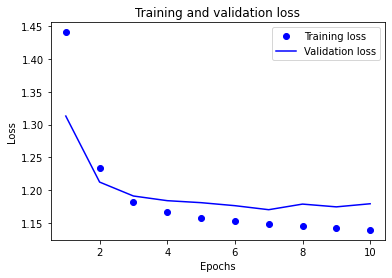

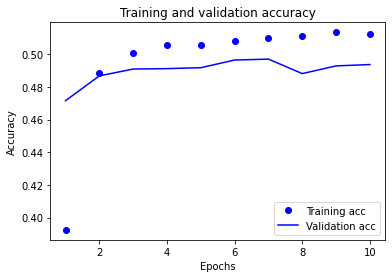

              precision    recall  f1-score   support

          tx       0.76      0.68      0.72      1177
         <1m       0.50      0.66      0.57       853
         <3m       0.23      0.02      0.03       587
         <1y       0.31      0.35      0.33       861
         >1y       0.53      0.66      0.59      1044

    accuracy                           0.52      4522
   macro avg       0.46      0.47      0.45      4522
weighted avg       0.50      0.52      0.50      4522



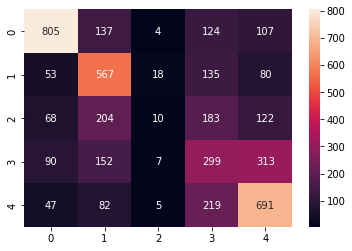

In [106]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m16.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 1*32 Neural Network

In [107]:
# 1*32 neural network
from keras.models import Sequential
from keras.layers import Dense

m32 = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m32.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m32.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
453/453 [==============================] - 2s 5ms/step - loss: 1.3782 - accuracy: 0.4245 - val_loss: 1.2568 - val_accuracy: 0.4737
Epoch 2/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1966 - accuracy: 0.4935 - val_loss: 1.2014 - val_accuracy: 0.4900
Epoch 3/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1631 - accuracy: 0.5026 - val_loss: 1.1895 - val_accuracy: 0.4873
Epoch 4/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1490 - accuracy: 0.5119 - val_loss: 1.1765 - val_accuracy: 0.4939
Epoch 5/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1395 - accuracy: 0.5164 - val_loss: 1.1799 - val_accuracy: 0.4942
Epoch 6/100
453/453 [==============================] - 1s 1ms/step - loss: 1.1333 - accuracy: 0.5184 - val_loss: 1.1739 - val_accuracy: 0.4961
Epoch 7/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1263 - accuracy: 0.5197 - val_loss: 1.1693 - val_accuracy: 0.4939

142/142 [==============================] - 0s 1ms/step


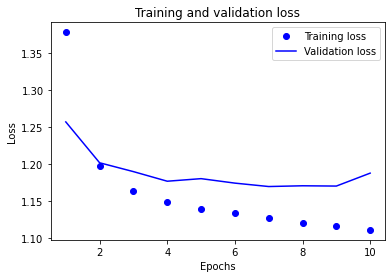

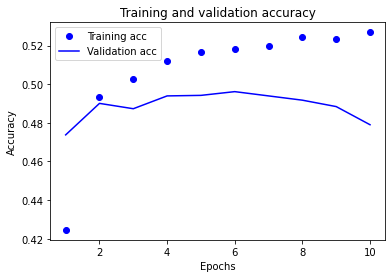

              precision    recall  f1-score   support

          tx       0.85      0.62      0.72      1177
         <1m       0.46      0.71      0.56       853
         <3m       0.24      0.03      0.05       587
         <1y       0.30      0.43      0.36       861
         >1y       0.55      0.55      0.55      1044

    accuracy                           0.51      4522
   macro avg       0.48      0.47      0.44      4522
weighted avg       0.52      0.51      0.49      4522



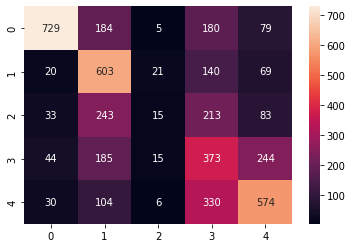

In [108]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m32.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)